In [1]:
from src.helpers.sequence_slider import SequenceSlider
from tools.config import load_config
from tools.logger import logger


from src.datasets.data_transformation import DataTransformation
from src.datasets.data_ingestion import DataIngestion

import pandas as pd
import numpy as  np

import torch
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# RNN's
from src.models.bi_lstm import BiLSTM


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,root_mean_squared_error,mean_squared_error,mean_absolute_percentage_error,mean_absolute_error

import matplotlib.pyplot as plt


config = load_config()
window_size = 7
obj = SequenceSlider(window_size)

train_scaled,test_scaled = DataTransformation(config).transform()

X_train,y_train,X_test,y_test = obj.transform(train=train_scaled,test=test_scaled)




2025-12-08 20:37:34 - INFO - tools.logger - 46 - shape of training data: (857, 1)
2025-12-08 20:37:34 - INFO - tools.logger - 56 - Length of training data: 685
2025-12-08 20:37:34 - INFO - tools.logger - 57 - Length of testing data: 172
2025-12-08 20:37:34 - INFO - tools.logger - 77 - Shape of training data scaled: (685, 1)
2025-12-08 20:37:34 - INFO - tools.logger - 78 - Shape of testing data: (172, 1)


In [2]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

(torch.Size([678, 7, 1]),
 torch.Size([165, 7, 1]),
 torch.Size([678, 1]),
 torch.Size([165, 1]))

In [3]:
# Bi-Directional LSTM

model = BiLSTM()

learning_rate = 0.001
epochs = 200
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.MSELoss()





In [4]:

for epoch in range(epochs):
    model.train()
    y_pred = model(X_train)
    loss = criterion(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 != 0:
        continue
    with torch.no_grad():
        model.eval()
        train_rmse = np.sqrt(criterion(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rmse = np.sqrt(criterion(y_pred_test,y_test))
        print(f"Epoch: {epoch}: Train_RMSE: {train_rmse:.4};TESTRMSE: {test_rmse:.4}")




/tmp/ipykernel_71505/1184512119.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(criterion(y_pred,y_train))
/tmp/ipykernel_71505/1184512119.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(criterion(y_pred_test,y_test))


Epoch: 0: Train_RMSE: 0.306;TESTRMSE: 0.06467
Epoch: 1: Train_RMSE: 0.1979;TESTRMSE: 0.2214
Epoch: 2: Train_RMSE: 0.2016;TESTRMSE: 0.2039
Epoch: 3: Train_RMSE: 0.1906;TESTRMSE: 0.1388
Epoch: 4: Train_RMSE: 0.1675;TESTRMSE: 0.09299
Epoch: 5: Train_RMSE: 0.1668;TESTRMSE: 0.07245
Epoch: 6: Train_RMSE: 0.1705;TESTRMSE: 0.0678
Epoch: 7: Train_RMSE: 0.1676;TESTRMSE: 0.07339
Epoch: 8: Train_RMSE: 0.1576;TESTRMSE: 0.09008
Epoch: 9: Train_RMSE: 0.1442;TESTRMSE: 0.117
Epoch: 10: Train_RMSE: 0.1353;TESTRMSE: 0.1422
Epoch: 11: Train_RMSE: 0.1357;TESTRMSE: 0.1417
Epoch: 12: Train_RMSE: 0.1303;TESTRMSE: 0.1108
Epoch: 13: Train_RMSE: 0.1095;TESTRMSE: 0.0657
Epoch: 14: Train_RMSE: 0.08962;TESTRMSE: 0.03363
Epoch: 15: Train_RMSE: 0.08502;TESTRMSE: 0.03741
Epoch: 16: Train_RMSE: 0.07878;TESTRMSE: 0.03559
Epoch: 17: Train_RMSE: 0.06149;TESTRMSE: 0.02834
Epoch: 18: Train_RMSE: 0.09138;TESTRMSE: 0.03779
Epoch: 19: Train_RMSE: 0.08137;TESTRMSE: 0.05955
Epoch: 20: Train_RMSE: 0.07331;TESTRMSE: 0.05892
Epoch:

- Use MinMaxScaler to undue scaler on data.

In [5]:
# load in DataIngestion


data = DataIngestion(config).fetch_fred_data()



# use training to have MinMaxScaler to be fitted on.
training = data.iloc[:, 0:1].values


In [6]:
train_length = int(len(training)*0.80)

train_length


685

In [7]:
# load int MinMaxScaler and use torch.no_grad() to undue scaler for predictions.


# instance of MaxMaxScaler
scaler = MinMaxScaler()

# fit instance of MinMaxScaler on training data
scaler.fit(training)


# torch remove scaler from y_pred and y_test

with torch.no_grad():
    y_pred = model(X_test)
    y_pred_np = y_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(y_pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)





In [8]:
# r2-score
r2 = r2_score(actual_rescaled,pred_rescaled)
print(f"R2 Score: {r2*100:.2f}")

# mean-square error
mse = mean_squared_error(actual_rescaled,pred_rescaled)
print(f"Mean Squared Error: {mse:.4}")

# Root Mean-Squared Error
rmse = root_mean_squared_error(actual_rescaled,pred_rescaled)
print(f"Root Mean-Squared Error: {rmse:.4}")

# mean absolute percentage error
mape = mean_absolute_percentage_error(actual_rescaled,pred_rescaled)
print(f"Mean Absolute Percentage Error: {mape:.4f}")


# mean absolute error
mae = mean_absolute_error(actual_rescaled,pred_rescaled)
print(f"Mean Absolute Error: {mae}")

R2 Score: 94.92
Mean Squared Error: 0.07056
Root Mean-Squared Error: 0.2656
Mean Absolute Percentage Error: 0.0760
Mean Absolute Error: 0.17956969141960144


In [9]:
# comparison of Actual Fed Funds Rate to Predicted

test_dates = data.iloc[train_length + window_size:]['date']

comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Fed Funds Rate": actual_rescaled.flatten(),
    "Predicted Fed Funds Rate":pred_rescaled.flatten()
})



print(f"First Ten Dates: {comparison_df.head(20)}")
print(f"Last Ten Dates: {comparison_df.tail(20)}")


First Ten Dates:           Date  Actual Fed Funds Rate  Predicted Fed Funds Rate
692 2012-03-01               1.271282                  1.379053
693 2012-04-01               1.331345                  1.344737
694 2012-05-01               1.411429                  1.367333
695 2012-06-01               1.411429                  1.425697
696 2012-07-01               1.621650                  1.435967
697 2012-08-01               1.661692                  1.618590
698 2012-09-01               1.941986                  1.697181
699 2012-10-01               2.162218                  1.952237
700 2012-11-01               2.222281                  2.198752
701 2012-12-01               2.332396                  2.299459
702 2013-01-01               2.462533                  2.399255
703 2013-02-01               2.432501                  2.518076
704 2013-03-01               2.482554                  2.507431
705 2013-04-01               2.482554                  2.536544
706 2013-05-01         

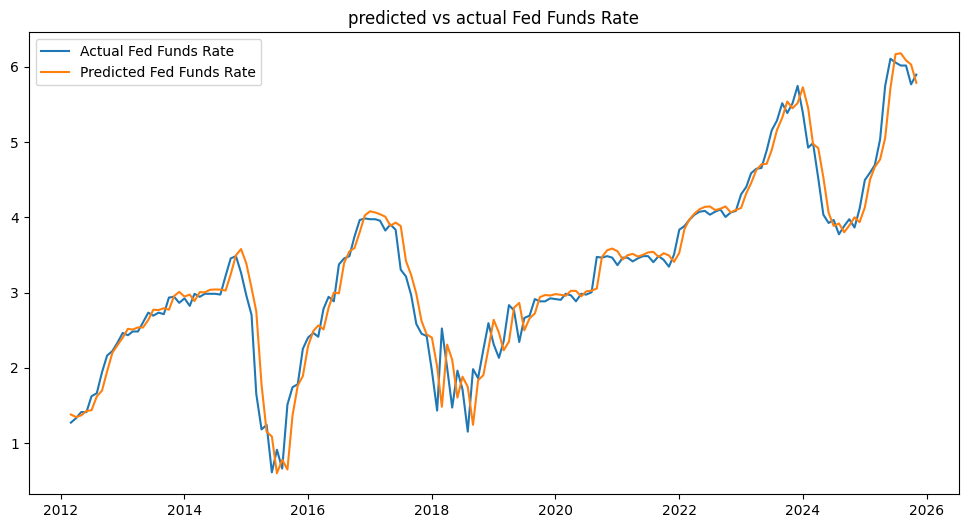

In [10]:


plt.figure(figsize=(12,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Fed Funds Rate"],label="Actual Fed Funds Rate")
plt.plot(comparison_df['Date'],comparison_df['Predicted Fed Funds Rate'],label="Predicted Fed Funds Rate")
plt.title("predicted vs actual Fed Funds Rate")
plt.savefig("images/lstm-forecast.png")
plt.legend()
plt.show()